# Cyber Security Statistical Inference Pipeline

Using [this](https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset) cyber security dataset on Kaggle, we will be using this dataset to discuss about most of the statistical tools that we have been learning about.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import networkx as nx

## EDA: What can lead to an `Attack`?

### Basic Cleaning

Basic cleaning of data set and som feature understanding:

In [19]:
df = pd.read_csv("data/cybersecurity_intrusion_data.csv")
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [65]:
df.shape

(9537, 13)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      9537 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [37]:
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


See who is more corrolated with `attack_detected`

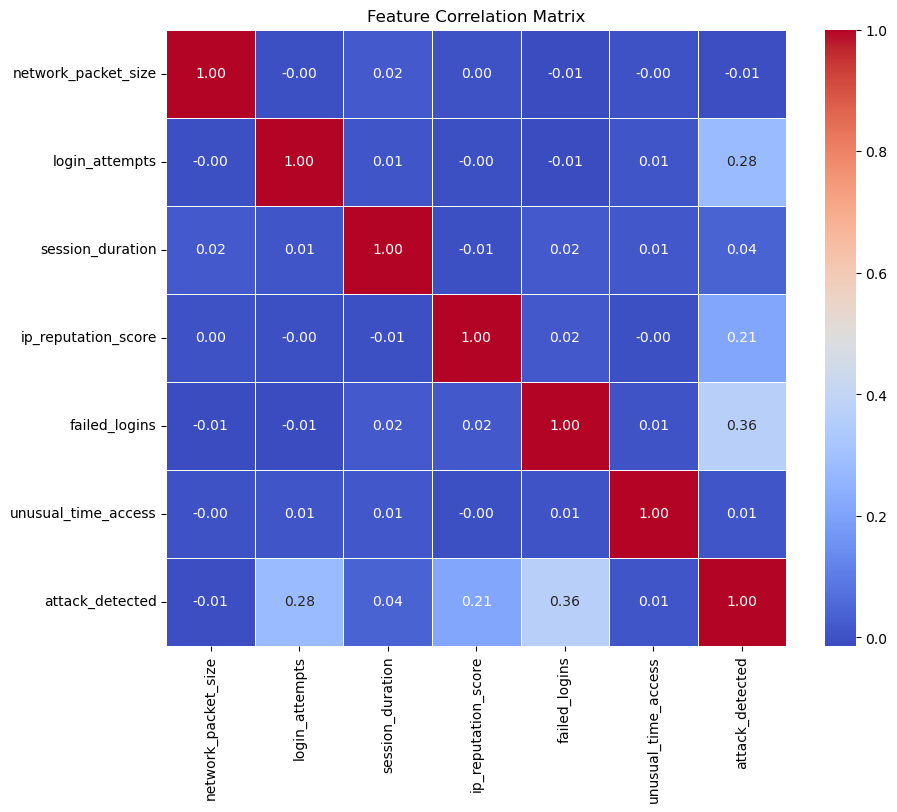

In [35]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

### Distributions

Looking at the distributions for attack vs non-attack scenarios

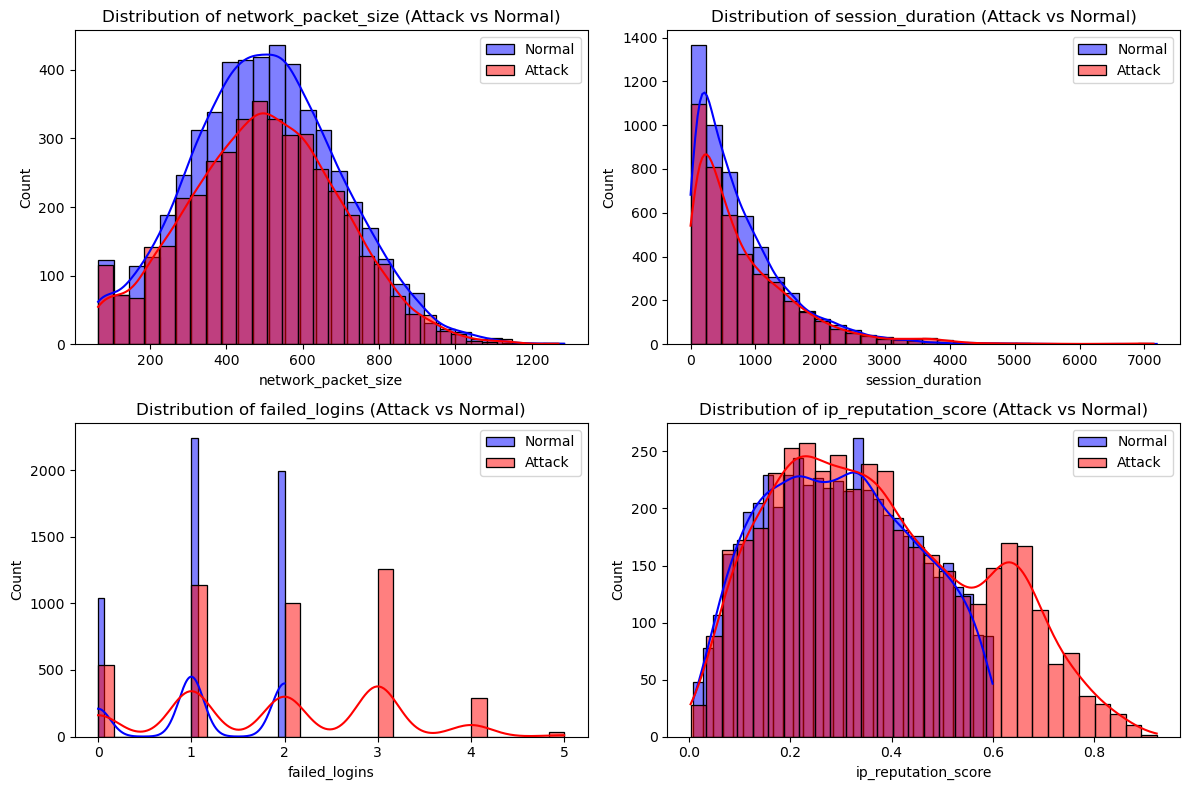

In [38]:
features_to_compare = ['network_packet_size', 'session_duration', 'failed_logins', 'ip_reputation_score']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_compare, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[df['attack_detected'] == 0][feature], label='Normal', kde=True, color='blue', bins=30)
    sns.histplot(df[df['attack_detected'] == 1][feature], label='Attack', kde=True, color='red', bins=30)
    plt.title(f'Distribution of {feature} (Attack vs Normal)')
    plt.legend()

plt.tight_layout()
plt.show()

### DImensionality Reduction

Looking at the ELBO PCA curve to decide the number of PCs we want to use

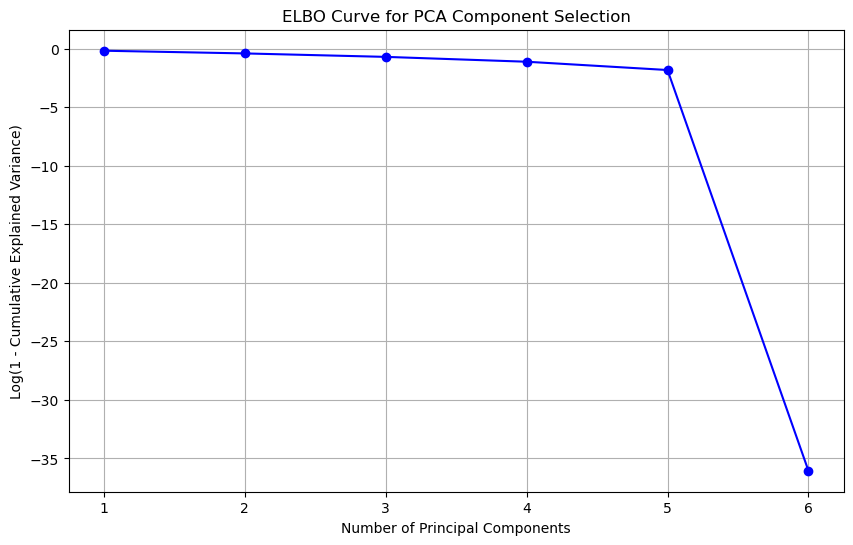

In [29]:
features = df.drop(columns=['attack_detected'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.select_dtypes(include=[np.number]))

pca = PCA()
pca.fit(scaled_features)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
elbo_curve = np.log(1 - cumulative_variance) 

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(elbo_curve) + 1), elbo_curve, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Log(1 - Cumulative Explained Variance)')
plt.title('ELBO Curve for PCA Component Selection')
plt.grid(True)
plt.show()

Conduct PCA to three dimensions

Explained Variance by Component: [0.17155328 0.17050284 0.16800122]
Total Explained Variance: 0.5101


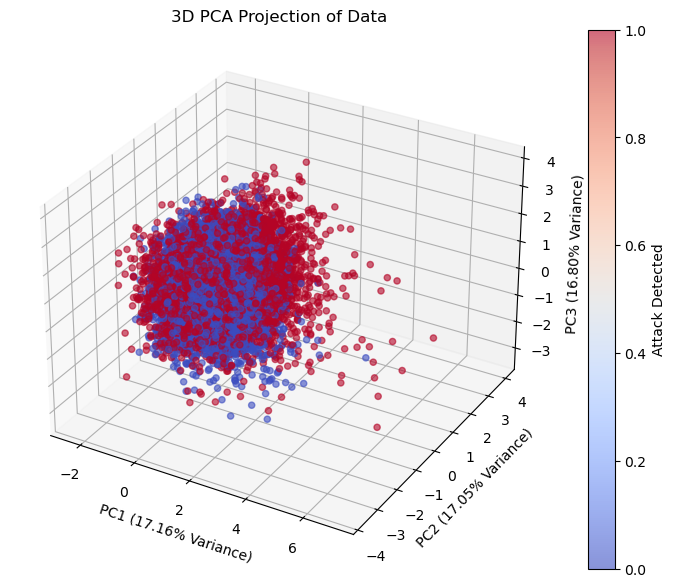

In [50]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component: {explained_variance}")
print(f"Total Explained Variance: {np.sum(explained_variance):.4f}")

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['attack_detected'] = df['attack_detected']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['attack_detected'], cmap='coolwarm', alpha=0.6)

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)')
ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}% Variance)')
ax.set_title('3D PCA Projection of Data')

plt.colorbar(scatter, ax=ax, label='Attack Detected')
plt.show()

### Feature Importance

Let's look at some feature importance

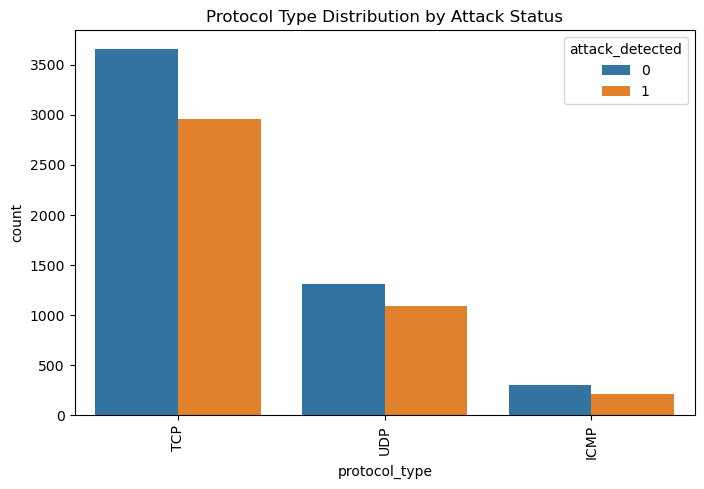

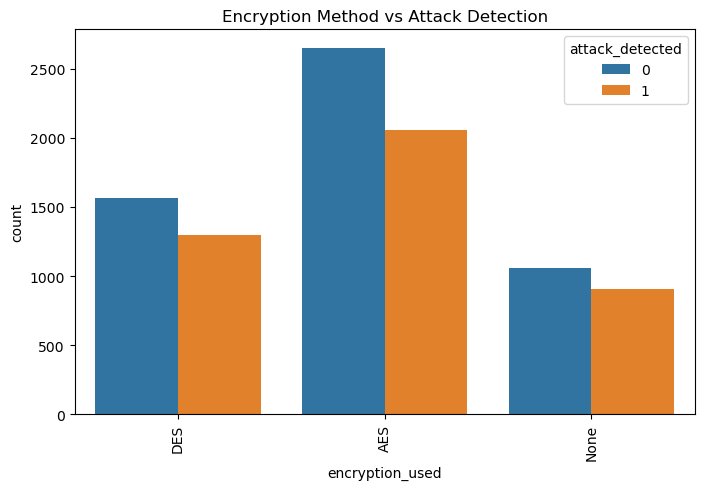

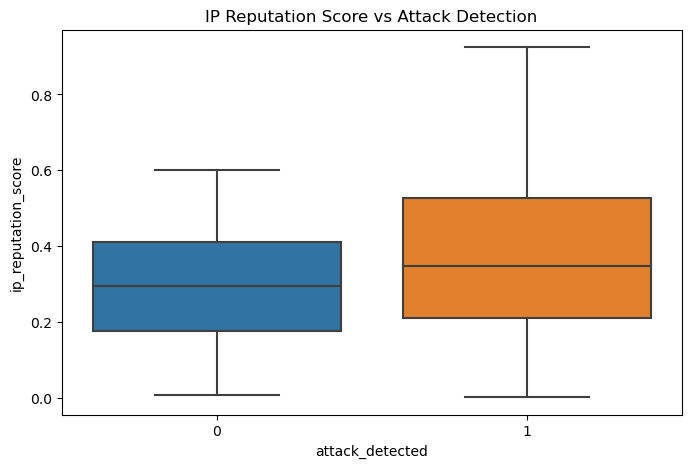

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(x='protocol_type', hue='attack_detected', data=df)
plt.title('Protocol Type Distribution by Attack Status')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='encryption_used', hue='attack_detected', data=df)
plt.title('Encryption Method vs Attack Detection')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='attack_detected', y='ip_reputation_score', data=df)
plt.title('IP Reputation Score vs Attack Detection')
plt.show()


Fit a random forest

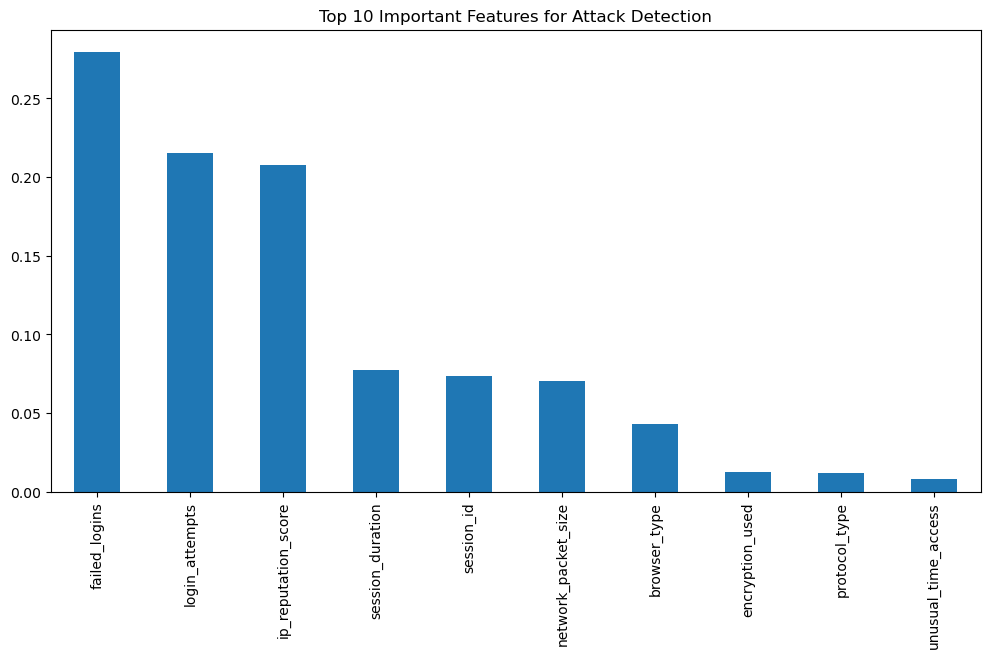

In [49]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # encoder for inverse transformation later

X = df.drop(columns=['attack_detected'])
y = df['attack_detected']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
importances[:10].plot(kind='bar')
plt.title('Top 10 Important Features for Attack Detection')
plt.show()

Feature interaction effects

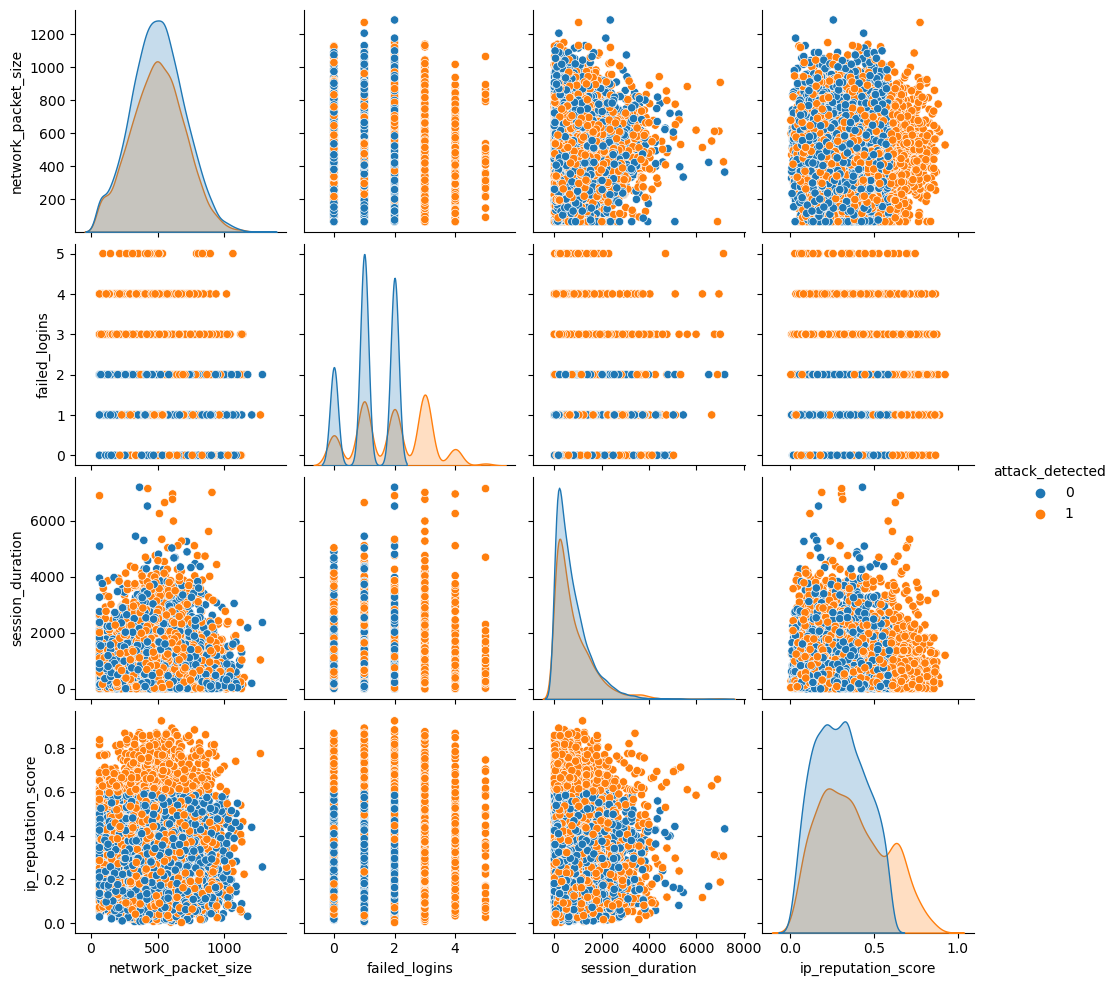

In [54]:
sns.pairplot(df[['network_packet_size', 'failed_logins', 'session_duration', 'ip_reputation_score', 'attack_detected']], hue='attack_detected')
plt.show()

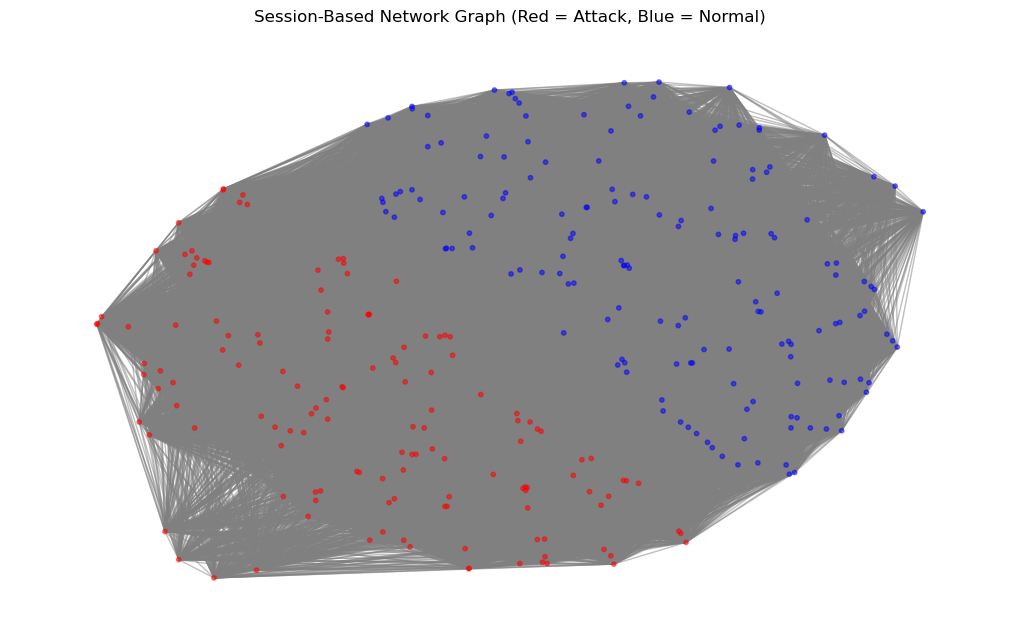

In [74]:
df_sample = df.sample(300)
G = nx.Graph()

# session_id as nodes
for session in df_sample['session_id']:
    G.add_node(session, attack=df_sample[df_sample['session_id'] == session]['attack_detected'].values[0])

# edges based on similarities
for i, row1 in df_sample.iterrows():
    for j, row2 in df_sample.iterrows():
        if i >= j: 
            continue
        
        same_attack_status = row1['attack_detected'] == row2['attack_detected']
        same_protocol = row1['protocol_type'] == row2['protocol_type']
        same_encryption = row1['encryption_used'] == row2['encryption_used']

        # if sessions share attack status, protocol, or encryption, connect them
        if same_attack_status or same_protocol or same_encryption:
            G.add_edge(row1['session_id'], row2['session_id'])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)

node_colors = ['red' if G.nodes[node]['attack'] == 1 else 'blue' for node in G.nodes]

nx.draw(G, pos, with_labels=False, node_size=10, node_color=node_colors, edge_color='gray', alpha=0.5)
plt.title("Session-Based Network Graph (Red = Attack, Blue = Normal)")
plt.show()

---
---

# Statsitcial Analysis: What Leads to An Attack?